# Tải dữ liệu bộ Vinafood

In [1]:
!pip install gdown

Link dư liêu: https://drive.usercontent.google.com/download?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR&export=download&authuser=0
- id: 1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR


In [2]:
!gdown --id 1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR -O vinafood21.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR
From (redirected): https://drive.google.com/uc?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR&confirm=t&uuid=7aba33ef-950b-4d32-b6a0-f52169b3fa11
To: /content/vinafood21.zip
100% 2.71G/2.71G [00:32<00:00, 82.2MB/s]


In [3]:
!unzip -q vinafood21.zip -d vinafood21

### Cài đặt pytorch

In [4]:
!pip install torch torchvision torchaudio

In [5]:
!ls /content/vinafood21/

VinaFood21


# Bài 3*: Xây dựng mô hình ResNet-18, đánh giá mô hình ResNet-18 trên bộ dữ liệu VinaFood21 sử dụng các độ đo precision, recall, và F1 (Sử dụng Adam làm optimizer).
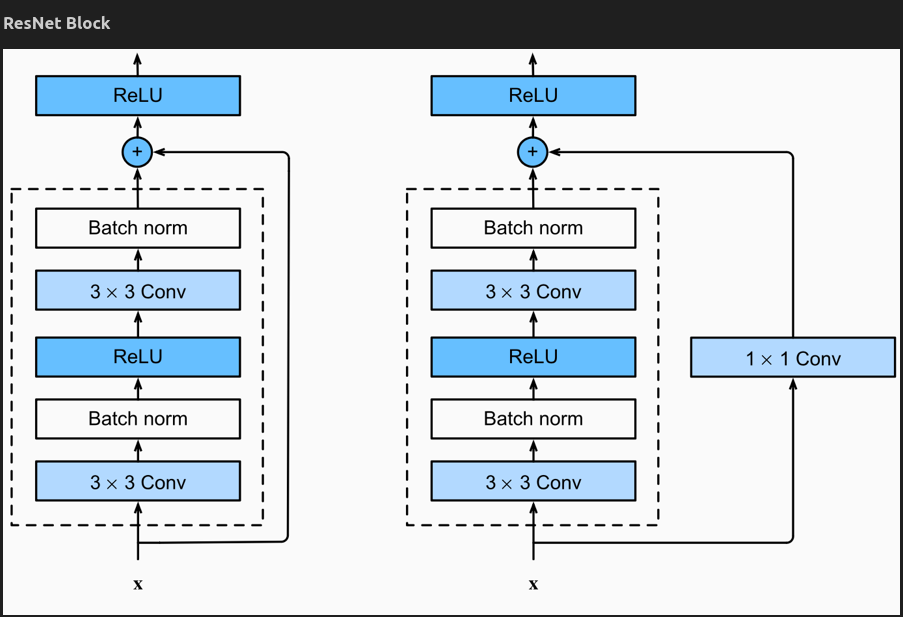

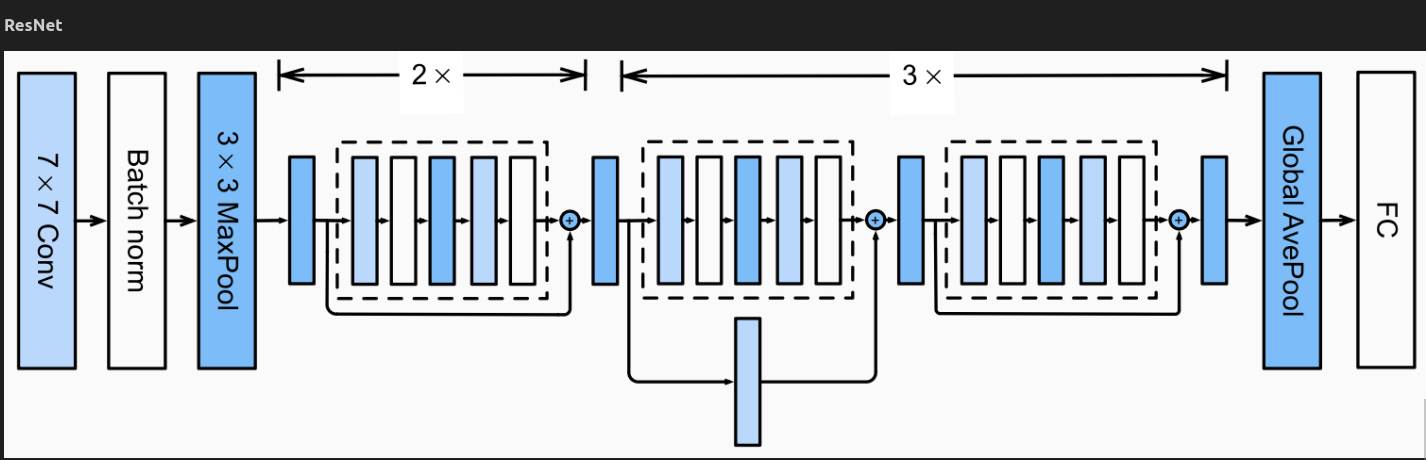

In [6]:
import torch
from torch.utils.data import Dataset
import os
import cv2 as cv


def collate_fn (samples: list[dict])->dict:
    images = [sample["image"] for sample in samples]
    labels = [sample["label"] for sample in samples]

    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)

    return {
        "images": images,
        "labels": labels
    }

class VinafoodDataset(Dataset):

    def __init__(self, path: str, image_size: tuple[int, int]):
        super().__init__()
        self.image_size = image_size

        self.label2idx = {}
        self.idx2label = {}

        self.data = self.load_data(path)

    def load_data(self, path: str):

        data = []
        label_id = 0

        for folder in os.listdir(path):
            label_name = folder
            if label_name not in self.label2idx:
                self.label2idx[label_name] = label_id
                self.idx2label[label_id] = label_name
                label_id += 1

            current_label_id = self.label2idx[label_name]
            folder_path = os.path.join(path, folder)

            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)


                data.append({
                    "image_path": image_path,
                    "label": current_label_id
                })

        return data



    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):

        item = self.data[index]
        image_path = item["image_path"]
        label = item["label"]


        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, self.image_size)

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.permute(2, 0, 1) # Chuyển từ (H, W, C) -> (C, H, W)

        return {
            "image": image,
            "label": label
        }

## Resnet block

In [7]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)

        if self.downsample is not None:
            identity = self.downsample(identity)

        output += identity
        output = self.relu(output)

        return output

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(out_channels=512, blocks=2, stride=2)

        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)
                # khởi tạo tham số
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

## Train and Evaluate

In [9]:
import numpy as np
import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

TRAIN_DATA_PATH = r"/content/vinafood21/VinaFood21/train"
TEST_DATA_PATH = r"/content/vinafood21/VinaFood21/test"
IMAGE_SIZE = (224, 224) # Kích thước ảnh tiêu chuẩn cho ResNet18
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

def evaluate(model: nn.Module, dataloader: DataLoader, device: str) -> dict:
    model.eval()
    predictions = []
    trues = []

    with torch.no_grad():
        for item in tqdm.tqdm(dataloader, desc="Evaluating"): # Use tqdm.tqdm() here
            images = item["images"].to(device)
            labels = item["labels"].to(device)
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)
            predictions.extend(outputs.cpu().tolist())
            trues.extend(labels.cpu().tolist())

    return {
        "accuracy": accuracy_score(trues, predictions),
        "precision": precision_score(trues, predictions, average="macro", zero_division=0),
        "recall": recall_score(trues, predictions, average="macro", zero_division=0),
        "f1": f1_score(trues, predictions, average="macro", zero_division=0),
    }



if __name__ == "__main__":
    # 1. Tải dữ liệu
    print("--- Đang tải dữ liệu... ---")
    train_dataset = VinafoodDataset(path=TRAIN_DATA_PATH, image_size=IMAGE_SIZE)
    test_dataset = VinafoodDataset(path=TEST_DATA_PATH, image_size=IMAGE_SIZE)

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2 # Tăng tốc độ nạp dữ liệu
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    print("--- Tải dữ liệu thành công! ---")



    # 2. Khởi tạo mô hình

    num_classes = len(train_dataset.label2idx)
    print(f"--- Số lượng lớp: {num_classes} ---")

    model = ResNet18(num_classes=num_classes).to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 3. Vòng lặp huấn luyện

    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
        model.train()
        losses = []

        #  thanh tiến trình tqdm
        for item in tqdm.tqdm(train_dataloader, desc="Training"): # Use tqdm.tqdm() here
            images = item["images"].to(device)
            labels = item["labels"].to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)

        print(f"Loss trung bình: {avg_loss:.4f}")

        # 4. Đánh giá mô hình sau mỗi epoch

        scores = evaluate(model, test_dataloader, device)
        print(f"Accuracy: {scores['accuracy']:.4f} | Precision: {scores['precision']:.4f} | Recall: {scores['recall']:.4f} | F1: {scores['f1']:.4f}")

    print("\n--- Huấn luyện hoàn tất! ---")

cuda
--- Đang tải dữ liệu... ---
--- Tải dữ liệu thành công! ---
--- Số lượng lớp: 21 ---

--- Epoch 1/10 ---


Training: 100%|██████████| 314/314 [01:37<00:00,  3.21it/s]


Loss trung bình: 2.6268


Evaluating: 100%|██████████| 209/209 [01:03<00:00,  3.29it/s]


Accuracy: 0.1570 | Precision: 0.2224 | Recall: 0.1459 | F1: 0.1279

--- Epoch 2/10 ---


Training: 100%|██████████| 314/314 [01:37<00:00,  3.22it/s]


Loss trung bình: 2.3344


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.34it/s]


Accuracy: 0.2038 | Precision: 0.2501 | Recall: 0.1921 | F1: 0.1595

--- Epoch 3/10 ---


Training: 100%|██████████| 314/314 [01:36<00:00,  3.24it/s]


Loss trung bình: 2.1732


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.33it/s]


Accuracy: 0.3043 | Precision: 0.3215 | Recall: 0.2670 | F1: 0.2618

--- Epoch 4/10 ---


Training: 100%|██████████| 314/314 [01:37<00:00,  3.23it/s]


Loss trung bình: 2.0393


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.32it/s]


Accuracy: 0.2646 | Precision: 0.3404 | Recall: 0.2221 | F1: 0.1846

--- Epoch 5/10 ---


Training: 100%|██████████| 314/314 [01:36<00:00,  3.26it/s]


Loss trung bình: 1.9366


Evaluating: 100%|██████████| 209/209 [01:03<00:00,  3.31it/s]


Accuracy: 0.2803 | Precision: 0.3396 | Recall: 0.2622 | F1: 0.2507

--- Epoch 6/10 ---


Training: 100%|██████████| 314/314 [01:36<00:00,  3.25it/s]


Loss trung bình: 1.7993


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.34it/s]


Accuracy: 0.3068 | Precision: 0.4381 | Recall: 0.2966 | F1: 0.2856

--- Epoch 7/10 ---


Training: 100%|██████████| 314/314 [01:36<00:00,  3.27it/s]


Loss trung bình: 1.6802


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.32it/s]


Accuracy: 0.3230 | Precision: 0.4135 | Recall: 0.2879 | F1: 0.2839

--- Epoch 8/10 ---


Training: 100%|██████████| 314/314 [01:36<00:00,  3.26it/s]


Loss trung bình: 1.5838


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.33it/s]


Accuracy: 0.4125 | Precision: 0.4222 | Recall: 0.3867 | F1: 0.3806

--- Epoch 9/10 ---


Training: 100%|██████████| 314/314 [01:35<00:00,  3.28it/s]


Loss trung bình: 1.4594


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.36it/s]


Accuracy: 0.4062 | Precision: 0.4759 | Recall: 0.3785 | F1: 0.3801

--- Epoch 10/10 ---


Training: 100%|██████████| 314/314 [01:37<00:00,  3.23it/s]


Loss trung bình: 1.3281


Evaluating: 100%|██████████| 209/209 [01:02<00:00,  3.37it/s]

Accuracy: 0.2652 | Precision: 0.4799 | Recall: 0.2278 | F1: 0.2263

--- Huấn luyện hoàn tất! ---


## Tuning Resnet-50

In [10]:
import torch
from torch import nn
from transformers import ResNetForImageClassification

class PretrainedResnet(nn.Module):
    def __init__(self):
        super().__init__()

        basemodel = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

        self.resnet = basemodel.resnet
        self.classifier = nn.Linear(in_features=2048, out_features=21, bias=True)

    def forward(self, images: torch.Tensor):
        features = self.resnet(images).pooler_output
        features = features.squeeze(-1).squeeze(-1)
        logits = self.classifier(features)

        return logits